This script will fetch locations of all venues in the Austin area that match a certain criteria (coffe, bar, bubble tea etc.).

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

print('folium imported')

folium imported


Since foursquare queries cannot return more than 50 venues at a time we have to run multiple scans to cover all the area.
To do this I will divide the area into square 1kmx1km cells.
1 KM is equal to 1/111 degrees. 

In [2]:
km=1/111
lat_A=30.2672
lng_A=-97.7431
lat=lat_A-km*7
lng=lng_A-km*10

Define functions that will later be used for calculating weight function.

In [3]:
def age_func(a):
    sss=12
    mu=20    yy=1/np.sqrt(2*3.1415*sss**2)*np.exp(-(a-mu)**2/(2*sss**2))/0.033245680287071734
    return yy

def dist_func(a):
    y=1/(1+np.exp((a-600)/100))
    return y

def inc_func(a):
    y=1-1/(1+np.exp((a-50000)/10000))
    return y

#optimization p

In [4]:
CLIENT_ID = 'SVC2EATH3GGQLSZVIQFAW1PH0O2RDX5K0H30ZJ3LOBKRR4SK' # your Foursquare ID
CLIENT_SECRET = '1A0VXT2XCTZ10JBCRLFKYNJDDHLTUHNIM43TTNY5WJ1DISL0' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SVC2EATH3GGQLSZVIQFAW1PH0O2RDX5K0H30ZJ3LOBKRR4SK
CLIENT_SECRET:1A0VXT2XCTZ10JBCRLFKYNJDDHLTUHNIM43TTNY5WJ1DISL0


Initialise the database with 4 columns: id of venue, name and geo coordinates.

In [5]:
col=['id','name','location.lat','location.lng']
db  = pd.DataFrame(columns = col)
db.head()
db.shape

(0, 4)

Run the search query with raduis of sqrt(2)*1KM for every node of the square grid. Save the information to db dataframe

In [6]:
radius = 1000*np.sqrt(2)
from pandas.io.json import json_normalize

n=30

gridx=np.linspace(lat,lat+15*km,n)
gridy=np.linspace(lng,lng+15*km,n)

for ind_i, i in enumerate(gridx):
    print(ind_i,'/',n)
    for j in gridy:
        search_query = 'coffee'
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, i, j, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        if venues!=[]:
            dataframe.head()
            df=dataframe[['id','name','location.lat','location.lng']].copy()
            frames = [db, df]
            db = pd.concat(frames)

0 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


In [71]:
db.head()

,id,name,location.lat,location.lng
0,4aa51b71f964a520674720e3,Starbucks,30.207837,-97.815372
0,584978d8e03e5771646253d8,Summer Moon Coffee Trailer,30.205375,-97.806272
0,579b791e498e9bd835c09ce6,Machine Head Coffee,30.210956,-97.771058
1,4f32165119836c91c7b47a90,Ag Horn Coffee Service Company,30.215841,-97.763750
0,58c549ff13c2236f0d0ffd8d,Ruta Maya Coffee,30.203389,-97.704302


Get rid of the duplicates because some venues were scanned multiple times.

In [8]:
db.drop_duplicates(inplace=True)
db.to_csv('coffee7.csv')
db.shape

(180, 4)

Load information about zipcodes, density, median income and age.

In [36]:
zip_demo=pd.read_csv('zip_all.csv')
zd=zip_demo.set_index('zip')
zd.head()

,lat,lng,den,income,age
zip,,,,,
78705,30.293474,-97.738268,11009,14740,21.2
78751,30.310819,-97.722821,5822,29799,28.1
78752,30.331288,-97.704660,5436,30207,27.1
78741,30.229845,-97.715136,5346,25369,23.9
78723,30.305341,-97.683344,5176,34242,28.3


In [26]:
X=pd.DataFrame(columns=['lat','lng','zip','density','income','age'])
X.loc[0]=[0,0,0,0,0,0]
X.head()


,lat,lng,zip,density,income,age
0,0,0,0,0,0,0


Assign zipcode, population density and demographics information to each cell, based on distance to the closest Central zipcode. 

In [ ]:
n=30
gridx=np.linspace(lat,lat+15*km,n)
gridy=np.linspace(lng,lng+15*km,n)


ind=0
for i in gridx:
    for j in gridy: 
        z=0
        m=10
        for k in zd.index:
            lat1=zd.loc[k]['lat']
            lng1=zd.loc[k]['lng']
            m1=(i-lat1)**2+(j-lng1)**2
            print(m1,lat1,lng1)
            if m1<m:
                m=m1
                z=k
                

        X.loc[ind]=[i,j,z,zd.loc[z]['den'],zd.loc[z]['income'],zd.loc[z]['age']]

        ind=ind+1




    

In [ ]:
X.to_csv('coffee_all.csv')

In [ ]:
db1=db.set_index('id')
db1.head()

Find the closest competing venue for each node. Calculate distance to the venue.

In [45]:

ind=0
s=db1.shape[0]
min_D=[]
for i in gridx:
    for j in gridy: 
        m=100
        for k in db1.index:
            lat1=db1.loc[k]['location.lat']
            lng1=db1.loc[k]['location.lng']
            m1=np.sqrt((i-lat1)**2+(j-lng1)**2)
            if m1<m:
                m=m1
        min_D.append(m)
        ind=ind+1

In [46]:
X1=pd.DataFrame(columns=['minD','f'])
Y = pd.concat([X, X1], axis=1, sort=False)



In [48]:
for i in range(len(min_D)):
    Y.at[i,'minD']=min_D[i]*111*1000 
#populate frame with average distance converted to meters

In [49]:
Y.to_csv('final_coffee.csv')
Y.head()

,lat,lng,zip,density,income,age,minD,f
0,30.2041,-97.8332,78749,2795,68244,32.2,1960.59,NaN
1,30.2041,-97.8285,78749,2795,68244,32.2,1517.25,NaN
2,30.2041,-97.8239,78745,4063,43458,31.3,1028.88,NaN
3,30.2041,-97.8192,78745,4063,43458,31.3,591.809,NaN
4,30.2041,-97.8146,78745,4063,43458,31.3,420.658,NaN


In [ ]:
print(age_func(32),dist_func(200))
Y.describe()

Calculate the weight function for each node.

In [51]:
function
for i in range(len(min_D)):
    den=Y.at[i,'density']
    inc=Y.at[i,'income']
    age=Y.at[i,'age']
    s=Y.at[i,'minD']
    Y.at[i,'f']=den*age_func(age)*(1+inc_func(inc)-dist_func(s)) 

Show it on the map!

In [70]:
Austin=folium.Map(location=[lat_A, lng_A], zoom_start=12)



ind=0
for i in gridx:
    for j in gridy:    
        folium.CircleMarker(
        [i, j],
        radius=6,
        color='blue',
        weight=0,
        fill=True,
        parse_html=False,
        fill_color='blue',
        fill_opacity=Y.at[ind,'f']/10000,  #
        line_opacity=0
        ).add_to(Austin)
        ind=ind+1
       
  
for lat, lng in zip(db['location.lat'],db['location.lng']):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        fill=False,
        parse_html=False).add_to(Austin)
  
    
       
Austin

In [ ]:
Y.head()

Supplementary part that shows functions used in calculation of weight function.

Text(0,0.5,'Coffee shop attendance')

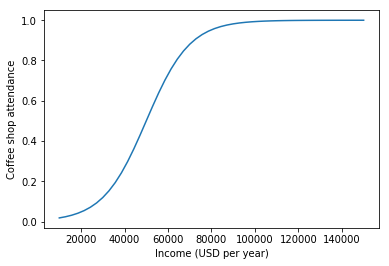

In [64]:
xx=np.linspace(10000,150000)
yy=inc_func(xx)
plt.plot(xx,yy)
plt.xlabel('Income (USD per year)')
plt.ylabel('Coffee shop attendance')


Text(0,0.5,'Coffee shop attendance')

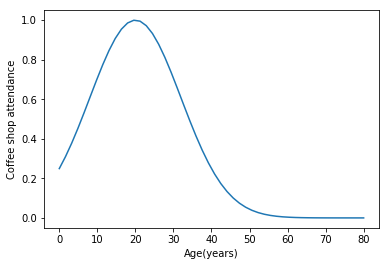

In [65]:
xx=np.linspace(0,80)
yy=age_func(xx)
plt.plot(xx,yy)
plt.xlabel('Age(years)')
plt.ylabel('Coffee shop attendance')

Text(0,0.5,'Competition')

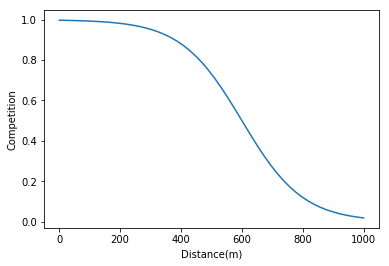

In [67]:
xx=np.linspace(0,1000)
yy=dist_func(xx)
plt.plot(xx,yy)
plt.xlabel('Distance(m)')
plt.ylabel('Competition')

(86, 4)